## Sort experiments from session recording

*To be used for a recording session that had to be restarted/has extra markers.*

This notebook partitions the processed MEG data into task-specific recordings and saves them to experiment folders. Using event markers, it identifies each task’s time spans, crops the SSS+ICA–cleaned Raw accordingly, preserves bad-channel lists and metadata, and writes event markers per experiment. Outputs are organized as:
- emcom (empathy & compassion) -- 4 FIF files from 4 blocks
- laryperc (English single-word perception) -- 3 FIF files from 3 blocks
- sarde_passive (Arabic passive listening) -- 1 FIF file from 1 block
- pharyperc (Arabic single-word perception) -- 1 FIF file from 1 block if applicable
- motor (all L/R key presses, including all experiments and breakout minigames) -- saved as epochs

In [1]:
# load packages
import numpy as np
import pandas as pd
import time
import os
import pickle
import mne
import sys
import re
from pathlib import Path
from mne.io import read_raw_fif
from mne import (pick_types, find_events, Epochs, Evoked, compute_covariance, write_cov, read_cov, setup_source_space,
                 write_source_spaces, make_bem_model, make_bem_solution, make_bem_solution, make_forward_solution,
                 write_forward_solution, read_forward_solution, write_bem_solution, convert_forward_solution, read_epochs, 
                 grade_to_vertices, read_source_estimate)
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs, apply_inverse, write_inverse_operator, read_inverse_operator
from mne.preprocessing import ICA
from mne.viz import plot_source_estimates
import matplotlib.pyplot as plt
mne.set_log_level(verbose='INFO')
np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

In [2]:
# session info
subject = 'nbl_004'
session = '01'
tasks = ['emcom', 'laryperc', 'sarde'] # 'pharyperc'

processed_meg_dir = '/mnt/sphere/nbl/processed_meg/'
raw_fname = os.path.join(processed_meg_dir, subject, 'ses-'+session, f"{subject}_ALL_post_ica-raw.fif")
print('Raw file:',raw_fname)

Raw file: /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_post_ica-raw.fif


In [3]:
# load data
print (f"Reading raw file for {subject}...")
t = time.time()
raw = read_raw_fif(raw_fname, preload=True, verbose=False)
elapsed_readraw = time.time() - t
print(f"Loaded in {elapsed_readraw:.1f} seconds.\n")

print (f"Reading events for {subject}...")
events = find_events(raw, stim_channel='STI101', min_duration=0.0015, verbose=False)
events[:, 0] = events[:, 0] - raw.first_samp # adjust for first sample in raw data
print(f"\n{events.shape[0]} events found with IDs {np.unique(events[:, 2])}")
for n in np.unique(events[:, 2]):
    print(f"- {(events[:, 2] == n).sum()} events with code {n}")

Reading raw file for nbl_004...
Loaded in 116.6 seconds.

Reading events for nbl_004...

5886 events found with IDs [  1   2  16  32 128]
- 91 events with code 1
- 432 events with code 2
- 2582 events with code 16
- 2773 events with code 32
- 8 events with code 128


Theres should be 3 events with code 128 (2 if the first one was sent before the recording started)

In [4]:
# event codes recorded in binary
excerpt_events = events[events[:, 2] == 1]       # emcom task: excerpt start
word_events = events[events[:, 2] == 2]          # laryperc task: word start
left_events = events[events[:, 2] == 16]         # left button press
right_events = events[events[:, 2] == 32]        # right button press
file_start_events = events[events[:, 2] == 128]  # start of file

In [5]:
def find_exp_files(task, subject, base_dir="/mnt/sphere/nbl/raw_behavior/data"):
    behav_dir = Path(base_dir) / task
    files = sorted(behav_dir.glob(f"*{subject}*.csv"))
    dfs = []
    for fp in files:
        try: dfs.append(pd.read_csv(fp))
        except Exception as e: print(f"Skipping {fp}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

rating_df = find_exp_files('rating', subject)
print('Rating:',len(rating_df),'annotations (first 1 is practice - no trigger sent)')
glottal_df = find_exp_files('glottal', subject)
print('Glottal:',len(glottal_df),'annotations')
breakout_df = find_exp_files('breakout', subject)
print('Breakout:',len(breakout_df),'annotations')

Rating: 92 annotations (first 1 is practice - no trigger sent)
Glottal: 432 annotations
Breakout: 5340 annotations


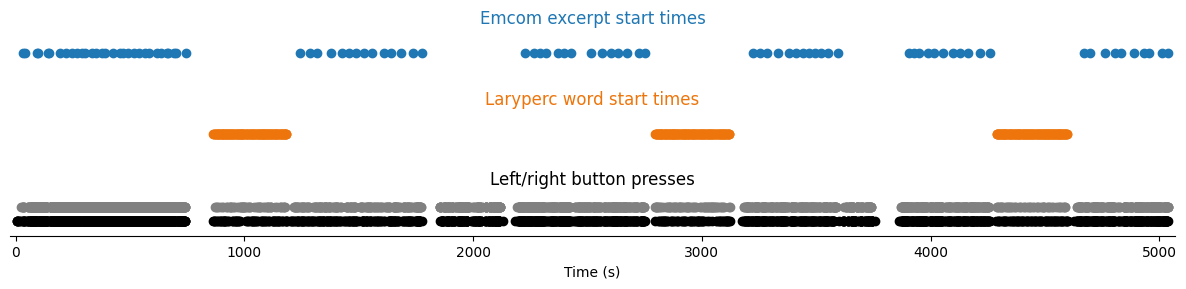

from behavioral logs


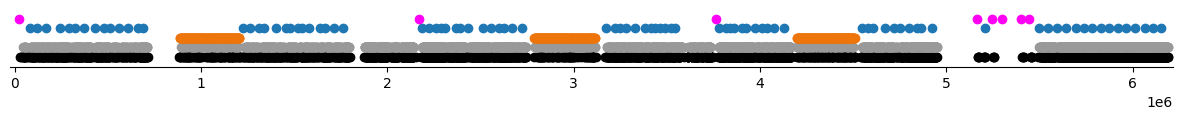

from MEG data (pink=start of new file)


In [6]:
fig, ax = plt.subplots(nrows=3, figsize=(12,3))
ax[0].scatter(rating_df.t_start.tolist(),np.ones(len(rating_df)), c='#1f77b4')
ax[0].spines['bottom'].set_visible(False)
ax[0].set_xticks([])
ax[0].set_title('Emcom excerpt start times', color='#1f77b4')
ax[1].scatter(glottal_df.response_start.tolist(),np.ones(len(glottal_df)), c='#ed750c')
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticks([])
ax[1].set_title('Laryperc word start times', color='#ed750c')
left = breakout_df[breakout_df['button']=='left']
right = breakout_df[breakout_df['button']=='right']
ax[2].scatter(right.t_start.tolist(),np.ones(len(right)), c='k')
ax[2].scatter(left.t_start.tolist(),2*np.ones(len(left)), c='grey')
ax[2].set_ylim([0,3])
ax[2].set_title('Left/right button presses')
ax[2].set_xlabel('Time (s)')
for a in ax:
    a.set_yticks([])
    a.set_xlim([min(rating_df['t_start'].tolist()
                    + glottal_df['response_start'].tolist()
                    + breakout_df['t_start'].tolist())-30, 
                max(rating_df['t_start'].tolist()
                    + glottal_df['response_start'].tolist()
                    + breakout_df['t_start'].tolist())+30])
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
print('from behavioral logs')

fig, ax = plt.subplots(figsize=(15,0.75))
ax.scatter(right_events[:,0], np.ones(len(right_events[:,0])), color='k')
ax.scatter(left_events[:,0], 2*np.ones(len(left_events[:,0])), color='#999999')
ax.scatter(word_events[:,0], 3*np.ones(len(word_events[:,0])), color='#ed750c')
ax.scatter(excerpt_events[:,0], 4*np.ones(len(excerpt_events[:,0])), color='#1f77b4')
ax.scatter(file_start_events[:,0], 5*np.ones(len(file_start_events[:,0])), color='#ff00f4')
ax.set_yticks([])
ax.set_xlim([-25000,max(right_events[:,0])+25000])
ax.set_ylim([-0.1,6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
print('from MEG data (pink=start of new file)')

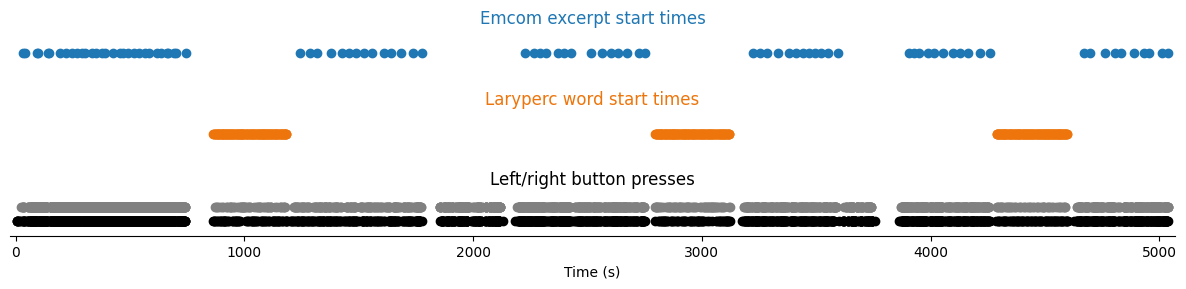

from behavioral logs


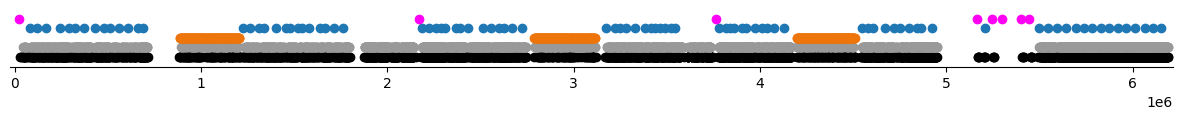

from MEG data (pink=start of new file)


In [6]:
fig, ax = plt.subplots(nrows=3, figsize=(12,3))
ax[0].scatter(rating_df.t_start.tolist(),np.ones(len(rating_df)), c='#1f77b4')
ax[0].spines['bottom'].set_visible(False)
ax[0].set_xticks([])
ax[0].set_title('Emcom excerpt start times', color='#1f77b4')
ax[1].scatter(glottal_df.response_start.tolist(),np.ones(len(glottal_df)), c='#ed750c')
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticks([])
ax[1].set_title('Laryperc word start times', color='#ed750c')
left = breakout_df[breakout_df['button']=='left']
right = breakout_df[breakout_df['button']=='right']
ax[2].scatter(right.t_start.tolist(),np.ones(len(right)), c='k')
ax[2].scatter(left.t_start.tolist(),2*np.ones(len(left)), c='grey')
ax[2].set_ylim([0,3])
ax[2].set_title('Left/right button presses')
ax[2].set_xlabel('Time (s)')
for a in ax:
    a.set_yticks([])
    a.set_xlim([min(rating_df['t_start'].tolist()
                    + glottal_df['response_start'].tolist()
                    + breakout_df['t_start'].tolist())-30, 
                max(rating_df['t_start'].tolist()
                    + glottal_df['response_start'].tolist()
                    + breakout_df['t_start'].tolist())+30])
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
print('from behavioral logs')

fig, ax = plt.subplots(figsize=(15,0.75))
ax.scatter(right_events[:,0], np.ones(len(right_events[:,0])), color='k')
ax.scatter(left_events[:,0], 2*np.ones(len(left_events[:,0])), color='#999999')
ax.scatter(word_events[:,0], 3*np.ones(len(word_events[:,0])), color='#ed750c')
ax.scatter(excerpt_events[:,0], 4*np.ones(len(excerpt_events[:,0])), color='#1f77b4')
ax.scatter(file_start_events[:,0], 5*np.ones(len(file_start_events[:,0])), color='#ff00f4')
ax.set_yticks([])
ax.set_xlim([-25000,max(right_events[:,0])+25000])
ax.set_ylim([-0.1,6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
print('from MEG data (pink=start of new file)')

#### Get first and last emcom/lary events per block

In [7]:
em = np.asarray(excerpt_events[:,0], dtype=int)
la = np.asarray(word_events[:,0], dtype=int)

# merge and sort by time
times  = np.concatenate([em, la])
labels = np.concatenate([np.zeros(len(em), dtype=int),  # 0 = emcom
                         np.ones(len(la), dtype=int)])  # 1 = laryperc
order  = np.argsort(times)
T, L   = times[order], labels[order]

# find contiguous runs of the same label
changes = np.flatnonzero(np.diff(L) != 0)
starts  = np.r_[0, changes + 1]
ends    = np.r_[changes, len(L) - 1]
run_lab  = L[starts]
run_first = T[starts]
run_last  = T[ends]
run_count = ends - starts + 1

# index nth run per label
em_idx = np.flatnonzero(run_lab == 0)
la_idx = np.flatnonzero(run_lab == 1)

def nth_first_last(idx_array, n):
    return (None, None) if n <= 0 or n > len(idx_array) else (
        int(run_first[idx_array[n-1]]), int(run_last[idx_array[n-1]])
    )

_,           em1_last   = nth_first_last(em_idx, 1)
lary1_first, lary1_last = nth_first_last(la_idx, 1)
em2_first,   em2_last   = nth_first_last(em_idx, 2)
lary2_first, lary2_last = nth_first_last(la_idx, 2)
em3_first,   em3_last   = nth_first_last(em_idx, 3)
lary3_first, lary3_last = nth_first_last(la_idx, 3)
em4_first,    _         = nth_first_last(em_idx, 4)

results = {
    "last emcom in block 1": em1_last,
    "first/last lary in block 1": (lary1_first, lary1_last),
    "first/last emcom in block 2": (em2_first, em2_last),
    "first/last lary in block 2": (lary2_first, lary2_last),
    "first/last emcom in block 3": (em3_first, em3_last),
    "first/last lary in block 3": (lary3_first, lary3_last),
    "first emcom in block 4": em4_first,
}

results

{'last emcom in block 1': 687145,
 'first/last lary in block 1': (886348, 1205432),
 'first/last emcom in block 2': (1226290, 2722012),
 'first/last lary in block 2': (2789383, 3114526),
 'first/last emcom in block 3': (3175941, 4130023),
 'first/last lary in block 3': (4198451, 4507778),
 'first emcom in block 4': 4545276}

In [8]:
combined = np.concatenate([left_events, right_events], axis=0)
button_presses = combined[np.argsort(combined[:, 0])]

In [40]:
emcom_1_s = 0
mask = right_events[:, 0] < lary1_first
emcom_1_e = int(right_events[np.where(mask)[0][-1]][0])

lary_1_s = emcom_1_e
mask = button_presses[:, 0] > lary1_last
lary_1_e = int(button_presses[np.where(mask)[0][1]][0])

emcom_2_s = lary_1_e
mask = right_events[:, 0] < lary2_first
emcom_2_e = int(right_events[np.where(mask)[0][-1]][0])

lary_2_s = emcom_2_e
mask = button_presses[:, 0] > lary2_last
lary_2_e = int(button_presses[np.where(mask)[0][1]][0])

emcom_3_s = lary_2_e
mask = right_events[:, 0] < lary3_first
emcom_3_e = int(right_events[np.where(mask)[0][-1]][0])

lary_3_s = emcom_3_e
mask = button_presses[:, 0] > lary3_last
lary_3_e = int(button_presses[np.where(mask)[0][1]][0])

emcom_4_s = lary_3_e
emcom_4_e = int(raw.last_samp - raw.first_samp)

sarde_first = int(em[-8:][0])
mask = right_events[:, 0] < sarde_first
sarde_s = int(right_events[np.where(mask)[0][-1]][0])
sarde_e = emcom_4_e

In [41]:
from pprint import pprint
def fmt(x): return "-" if x is None else f"{int(x):,}"

em1_last = results['last emcom in block 1']
la1_first, la1_last = results['first/last lary in block 1']
em2_first, em2_last = results['first/last emcom in block 2']
la2_first, la2_last = results['first/last lary in block 2']
em3_first, em3_last = results['first/last emcom in block 3']
la3_first, la3_last = results['first/last lary in block 3']
em4_first = results['first emcom in block 4']

rows = [
    ("emcom 1", None,       em1_last,  emcom_1_s, emcom_1_e),
    ("lary  1", la1_first,  la1_last,  lary_1_s,  lary_1_e),
    ("emcom 2", em2_first,  em2_last,  emcom_2_s, emcom_2_e),
    ("lary  2", la2_first,  la2_last,  lary_2_s,  lary_2_e),
    ("emcom 3", em3_first,  em3_last,  emcom_3_s, emcom_3_e),
    ("lary  3", la3_first,  la3_last,  lary_3_s,  lary_3_e),
    ("emcom 4", em4_first,  None,      emcom_4_s, emcom_4_e),
    ("sarde",  sarde_first, None,      sarde_s,   sarde_e),
]

print("\nExperiment blocks (times in samples):")
print(f"{'Block':<8} {'First event':>14} {'Last event':>14}   {'idx_start':>10} {'idx_end':>10}")
print("-" * 66)
for name, first_t, last_t, i_s, i_e in rows:
    print(f"{name:<8} {fmt(first_t):>14} {fmt(last_t):>14}   {fmt(i_s):>10} {fmt(i_e):>10}")


Experiment blocks (times in samples):
Block       First event     Last event    idx_start    idx_end
------------------------------------------------------------------
emcom 1               -        687,145            0    884,298
lary  1         886,348      1,205,432      884,298  1,209,402
emcom 2       1,226,290      2,722,012    1,209,402  2,787,343
lary  2       2,789,383      3,114,526    2,787,343  3,118,856
emcom 3       3,175,941      4,130,023    3,118,856  4,196,405
lary  3       4,198,451      4,507,778    4,196,405  4,510,264
emcom 4       4,545,276              -    4,510,264  6,245,999
sarde         5,495,746              -    5,494,521  6,245,999


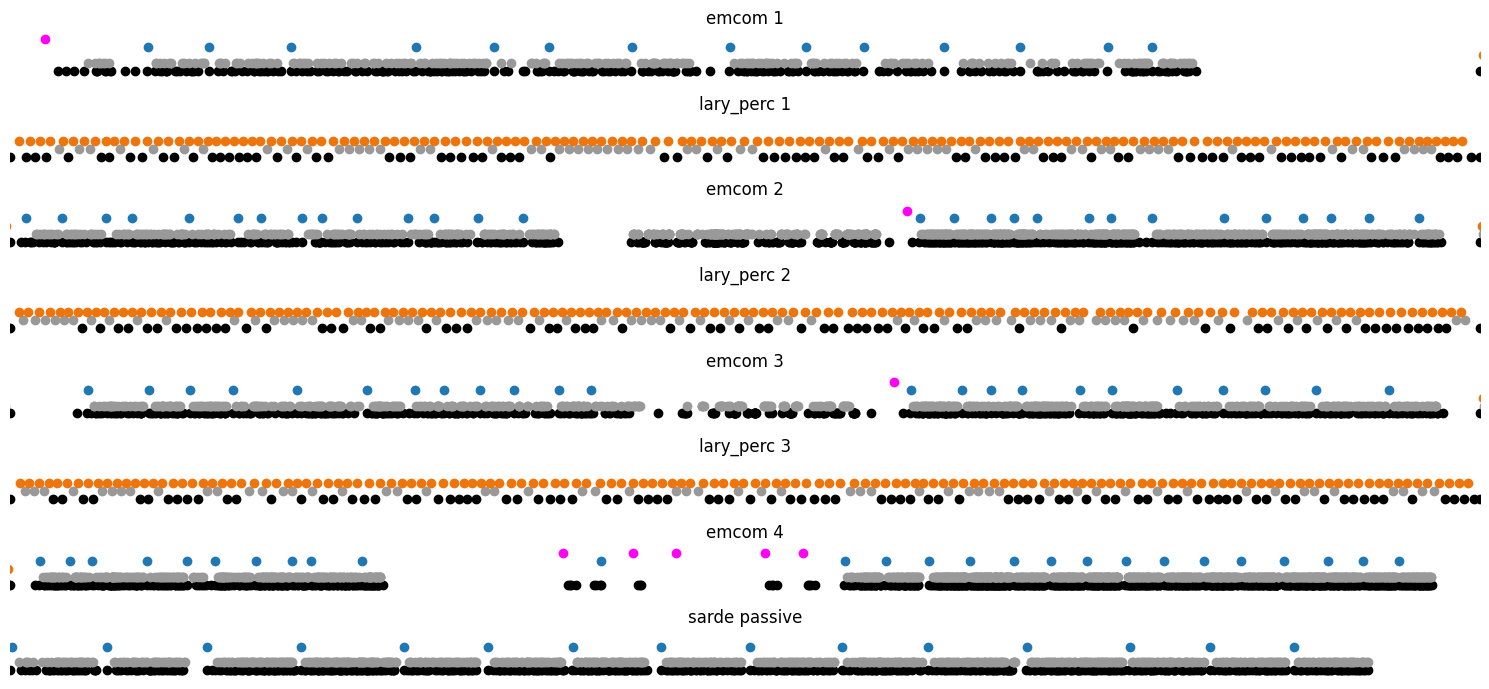

In [42]:
def plot_experiment(ax, start, stop, title):
    ax.scatter(right_events[:,0], np.ones(len(right_events[:,0])), color='k')
    ax.scatter(left_events[:,0], 2*np.ones(len(left_events[:,0])), color='#999999')
    ax.scatter(word_events[:,0], 3*np.ones(len(word_events[:,0])), color='#ed750c')
    ax.scatter(excerpt_events[:,0], 4*np.ones(len(excerpt_events[:,0])), color='#1f77b4')
    ax.scatter(file_start_events[:,0], 5*np.ones(len(file_start_events[:,0])), color='#ff00f4')
    ax.set_yticks([]);  ax.set_xticks([])
    ax.set_xlim([start, stop])
    ax.set_ylim([-0.1,6])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(title)

fig, ax = plt.subplots(nrows=8, figsize=(15,7))
plot_experiment(ax[0], emcom_1_s, emcom_1_e, 'emcom 1')
plot_experiment(ax[1], lary_1_s,  lary_1_e, 'lary_perc 1')
plot_experiment(ax[2], emcom_2_s, emcom_2_e, 'emcom 2')
plot_experiment(ax[3], lary_2_s,  lary_2_e, 'lary_perc 2')
plot_experiment(ax[4], emcom_3_s, emcom_3_e, 'emcom 3')
plot_experiment(ax[5], lary_3_s,  lary_3_e, 'lary_perc 3')
plot_experiment(ax[6], emcom_4_s, emcom_4_e, 'emcom 4')
plot_experiment(ax[7], sarde_s, sarde_e, 'sarde passive')
plt.tight_layout()
plt.show()

### Slice and save

In [43]:
# save out emcom blocks
emcom_dir = os.path.join(processed_meg_dir,subject,'ses-'+session,'emcom')
os.makedirs(emcom_dir, exist_ok=True)
emcom_blocks = []

raw_segment = raw.copy().crop(tmax=emcom_1_e/raw.info['sfreq'])
events_segment = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
emcom_blocks.append(len(events_segment[events_segment[:, 2] == 1]))
raw_segment.save(os.path.join(emcom_dir, 'emcom_1_raw.fif'), overwrite=True)

raw_segment = raw.copy().crop(tmin=emcom_2_s/raw.info['sfreq'], tmax=emcom_2_e/raw.info['sfreq'])
events_segment = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
emcom_blocks.append(len(events_segment[events_segment[:, 2] == 1]))
raw_segment.save(os.path.join(emcom_dir, 'emcom_2_raw.fif'), overwrite=True)

raw_segment = raw.copy().crop(tmin=emcom_3_s/raw.info['sfreq'], tmax=emcom_3_e/raw.info['sfreq'])
events_segment = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
emcom_blocks.append(len(events_segment[events_segment[:, 2] == 1]))
raw_segment.save(os.path.join(emcom_dir, 'emcom_3_raw.fif'), overwrite=True)

# raw_segment = raw.copy().crop(tmin=emcom_4_s/raw.info['sfreq'])
# events_segment = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
# emcom_blocks.append(len(events_segment[events_segment[:, 2] == 1]))
# raw_segment.save(os.path.join(emcom_dir, 'emcom_4_raw.fif'), overwrite=True)

# save out laryperc blocks
lary_dir = os.path.join(processed_meg_dir,subject,'ses-'+session,'laryperc')
os.makedirs(lary_dir, exist_ok=True)
lary_blocks = []

raw_segment = raw.copy().crop(tmin=lary_1_s/raw.info['sfreq'], tmax=lary_1_e/raw.info['sfreq'])
events_segment = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
lary_blocks.append(len(events_segment[events_segment[:, 2] == 2]))
raw_segment.save(os.path.join(lary_dir, 'laryperc_1_raw.fif'), overwrite=True)

raw_segment = raw.copy().crop(tmin=lary_2_s/raw.info['sfreq'], tmax=lary_2_e/raw.info['sfreq'])
events_segment = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
lary_blocks.append(len(events_segment[events_segment[:, 2] == 2]))
raw_segment.save(os.path.join(lary_dir, 'laryperc_2_raw.fif'), overwrite=True)

raw_segment = raw.copy().crop(tmin=lary_3_s/raw.info['sfreq'], tmax=lary_3_e/raw.info['sfreq'])
events_segment = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
lary_blocks.append(len(events_segment[events_segment[:, 2] == 2]))
raw_segment.save(os.path.join(lary_dir, 'laryperc_3_raw.fif'), overwrite=True)

# save out sarde passive block
sarde_dir = os.path.join(processed_meg_dir,subject,'ses-'+session,'sarde')
os.makedirs(sarde_dir, exist_ok=True)

raw_segment = raw.copy().crop(tmin=sarde_s/raw.info['sfreq'], tmax=sarde_e/raw.info['sfreq'])
raw_segment.save(os.path.join(sarde_dir, 'sardepassive_1_raw.fif'), overwrite=True)

Writing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_1_raw.fif
Closing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_1_raw.fif
[done]
Writing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_2_raw.fif
Closing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_2_raw.fif
[done]
Writing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_3_raw.fif
Closing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_3_raw.fif
[done]
Writing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/laryperc/laryperc_1_raw.fif
Closing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/laryperc/laryperc_1_raw.fif
[done]
Writing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/laryperc/laryperc_2_raw.fif
Closing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/laryperc/laryperc_2_raw.fif
[done]
Writing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/laryperc/laryperc_3_raw.fif
Closing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/laryperc/laryperc_3_raw.fif
[done]
Writing /mnt/sphere/nb

[PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/sarde_passive/sardepassive_1_raw.fif')]

In [ ]:
# # save out pharypercblock
# if 'pharyperc' in tasks:
#     phary_dir = os.path.join(processed_meg_dir,subject,'ses-'+session,'pharyperc')
#     os.makedirs(phary_dir, exist_ok=True)

In [98]:
# fix emcom 4 using file_start_events
mask = right_events[:, 0] < file_start_events[3][0]
file_end = right_events[mask][-1][0]
new_file_start = file_start_events[-1][0]

raw_segment = raw.copy().crop(tmin=emcom_4_s/raw.info['sfreq'], tmax=file_end/raw.info['sfreq'])
raw_segment_2 = raw.copy().crop(tmin=new_file_start/raw.info['sfreq'])
mne.concatenate_raws([raw_segment, raw_segment_2], verbose=False)

<Raw | nbl_004_ALL_post_ica-raw-2.fif, 319 x 1240174 (1240.2 s), ~2.95 GiB, data loaded>

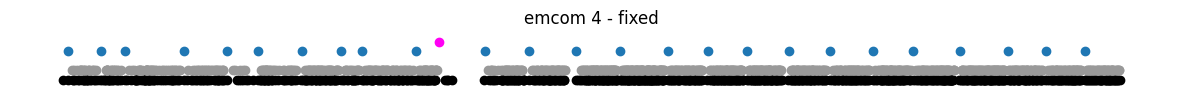

In [94]:
emcom_4_events = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
emcom_4_excerpt_events = emcom_4_events[emcom_4_events[:, 2] == 1]       # emcom task: excerpt start
emcom_4_word_events = emcom_4_events[emcom_4_events[:, 2] == 2]          # laryperc task: word start
emcom_4_left_events = emcom_4_events[emcom_4_events[:, 2] == 16]         # left button press
emcom_4_right_events = emcom_4_events[emcom_4_events[:, 2] == 32]        # right button press
emcom_4_file_start_events = emcom_4_events[emcom_4_events[:, 2] == 128]  # start of file

fig, ax = plt.subplots(figsize=(15,0.75))
ax.scatter(emcom_4_right_events[:,0], np.ones(len(emcom_4_right_events[:,0])), color='k')
ax.scatter(emcom_4_left_events[:,0], 2*np.ones(len(emcom_4_left_events[:,0])), color='#999999')
ax.scatter(emcom_4_word_events[:,0], 3*np.ones(len(emcom_4_word_events[:,0])), color='#ed750c')
ax.scatter(emcom_4_excerpt_events[:,0], 4*np.ones(len(emcom_4_excerpt_events[:,0])), color='#1f77b4')
ax.scatter(emcom_4_file_start_events[:,0], 5*np.ones(len(emcom_4_file_start_events[:,0])), color='#ff00f4')
ax.set_yticks([]);  ax.set_xticks([])
ax.set_ylim([-0.1,6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('emcom 4 - fixed')
plt.show()

In [85]:
# fix emcom 4
events_segment = find_events(raw_segment, stim_channel='STI101', min_duration=0.0015, verbose=False)
emcom_blocks.append(len(events_segment[events_segment[:, 2] == 1]))
raw_segment.save(os.path.join(emcom_dir, 'emcom_4_raw.fif'), overwrite=True)

Writing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_4_raw.fif
Closing /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_4_raw.fif
[done]


[PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/emcom/emcom_4_raw.fif')]

In [89]:
emcom_blocks

[14, 28, 23, 25]

### Save out behavior logs

In [91]:
rating_df_trimmed = rating_df.drop(columns=['thisRow.t', 'notes', 'Unnamed: 15', 'glottal'])
rating_df_trimmed = rating_df_trimmed.iloc[1:]
rating_df_trimmed['FIF'] = None
eb = [0] + list(np.cumsum(emcom_blocks))
for i in range(len(eb)-1):
    fname = os.path.join(emcom_dir, f'emcom_{i+1}_raw.fif')
    rating_df_trimmed.iloc[eb[i]:eb[i+1], rating_df_trimmed.columns.get_loc('FIF')] = fname
rating_df_trimmed.to_csv(os.path.join(emcom_dir, 'emcom_events.csv'), index=False)

In [92]:
sarde_df = rating_df_trimmed.tail(8)
sarde_df.to_csv(os.path.join(sarde_dir, 'sardepassive_events.csv'), index=False)

In [93]:
glottal_df_trimmed = glottal_df.drop(columns=['thisRow.t', 'notes', 'Unnamed: 15', 'glottal'])
glottal_df_trimmed['glottal_block'] = glottal_df_trimmed['glottal_block'] // 2
glottal_df_trimmed['FIF'] = glottal_df_trimmed['glottal_block'].apply(lambda i: os.path.join(lary_dir, f'laryperc_{i+1}_raw.fif'))
glottal_df_trimmed.to_csv(os.path.join(lary_dir, 'laryperc_events.csv'), index=False)

### Motor responses across all experiments

In [99]:
motor_dir = os.path.join(processed_meg_dir,subject,'ses-'+session,'motor')
os.makedirs(motor_dir, exist_ok=True)

In [106]:
event_dict = {'left_press': 16, 'right_press': 32}
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.5, tmax=1.5, picks='meg', preload=True, verbose=True)
epochs.save(os.path.join(motor_dir,'button_press-epo.fif'), overwrite=True)

Not setting metadata
5355 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5355 events and 2001 original time points ...
0 bad epochs dropped
Overwriting existing file.
Splitting into 7 parts
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


[PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/motor/button_press-epo.fif'),
 PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/motor/button_press-epo-1.fif'),
 PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/motor/button_press-epo-2.fif'),
 PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/motor/button_press-epo-3.fif'),
 PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/motor/button_press-epo-4.fif'),
 PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/motor/button_press-epo-5.fif'),
 PosixPath('/mnt/sphere/nbl/processed_meg/nbl_004/ses-01/motor/button_press-epo-6.fif')]

In [107]:
breakout_df_trimmed = breakout_df.drop(columns=['thisRow.t', 'notes', 'Unnamed: 10', 'glottal'])
breakout_df_trimmed.to_csv(os.path.join(motor_dir,'button_press_events.csv'), index=False)

#### Plot motor-evoked responses

In [108]:
left_evoked = epochs['left_press'].average()
right_evoked = epochs['right_press'].average()

In [124]:
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, exclude='bads')
locs = np.array([raw.info['chs'][p]['loc'][:3] for p in picks_meg])
x, y = locs[:, 0], locs[:, 1]

max_angle_deg = 60  # 1–3 o'clock ≈ within 60° of the +x axis (mirrored for left)
theta = np.degrees(np.arctan2(np.maximum(y, 0), np.abs(x)))  # 0..90°, only anterior y>0

frontal_narrow = (y > 0) & (theta <= max_angle_deg)
left_frontal_picks  = np.array(picks_meg)[(x < 0) & frontal_narrow].tolist()
right_frontal_picks = np.array(picks_meg)[(x > 0) & frontal_narrow].tolist()

left_frontal_chans  = [raw.ch_names[i] for i in left_frontal_picks]
right_frontal_chans = [raw.ch_names[i] for i in right_frontal_picks]

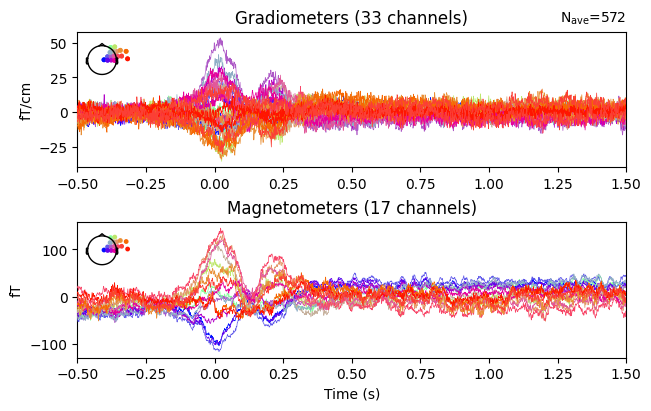

In [125]:
time_window = (-0.5, 0.5)
left_evoked.plot(picks=right_frontal_chans);

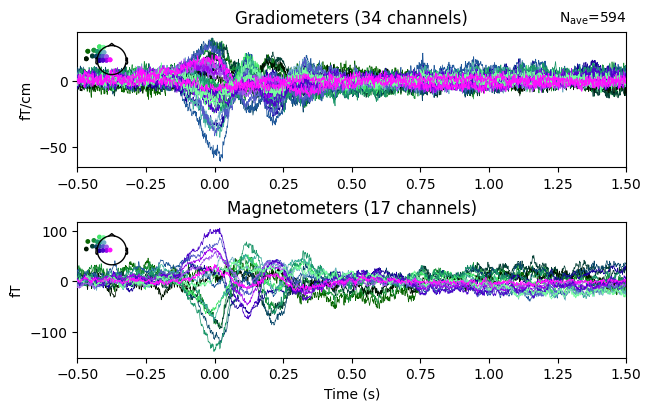

In [126]:
right_evoked.plot(picks=left_frontal_chans);

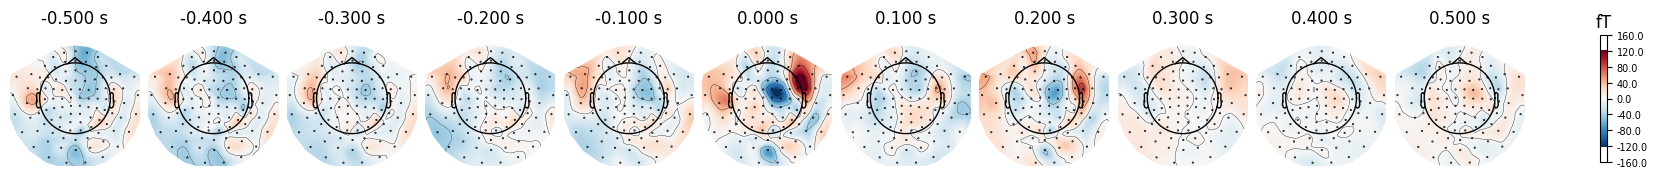

In [127]:
times = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
left_evoked.plot_topomap(times=times, ch_type='mag', colorbar=True);

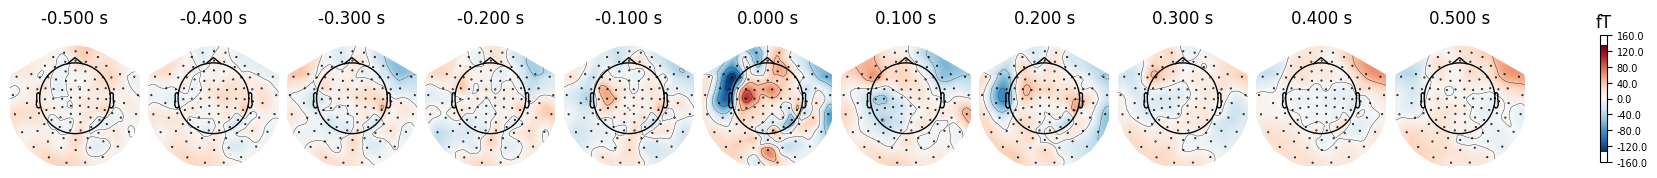

In [128]:
right_evoked.plot_topomap(times=times, ch_type='mag', colorbar=True);

In [115]:
evokeds = mne.read_evokeds(os.path.join(processed_meg_dir, subject, 'ses-'+session, f"{subject}_bigfrank_2_ave.fif"))
for i, evoked in enumerate(evokeds): print(f"{i}: {evoked.comment} - {evoked.nave} averages")

Reading /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_bigfrank_2_ave.fif ...
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms (left press)
        0 CTF compensation matrices available
        nave = 572 - aspect type = 100
Created an SSP operator (subspace dimension = 13)
13 projection ite

Projections have already been applied. Setting proj attribute to True.


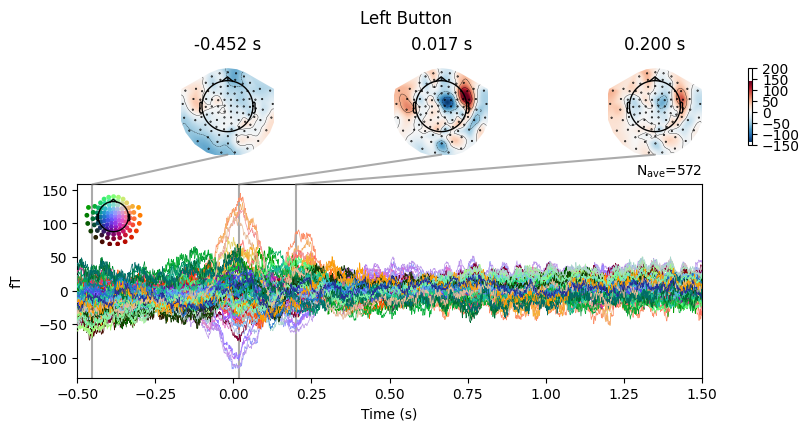

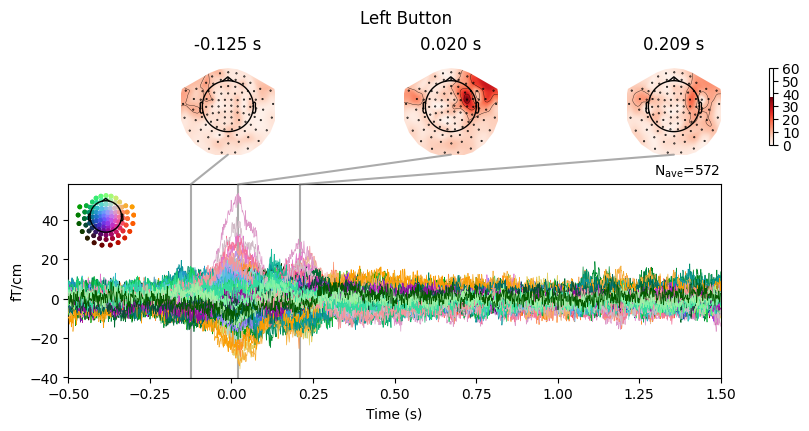

Projections have already been applied. Setting proj attribute to True.


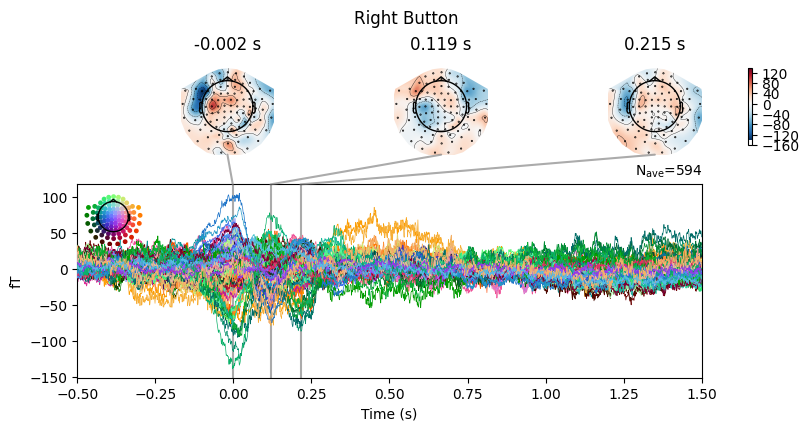

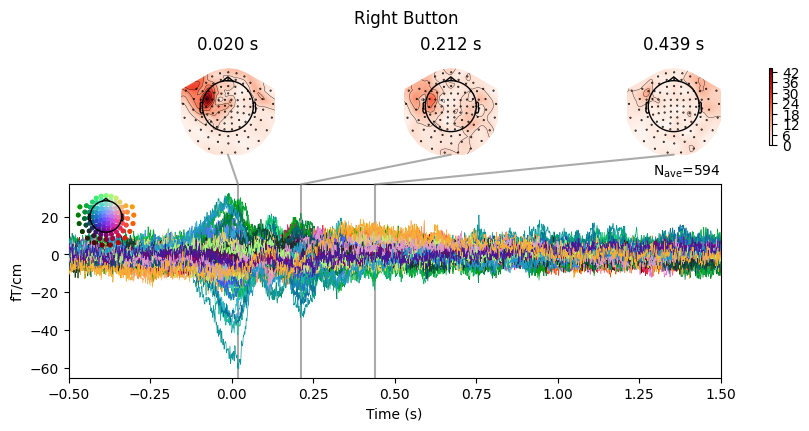

In [116]:
left_evoked = evokeds[0]
right_evoked = evokeds[1]

left_evoked.plot_joint(title='Left Button');
right_evoked.plot_joint(title='Right Button');